In [2]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

# 计算性能
> 这一个章节对于算法的学习而言不是很重要, 所以暂时看一下
## 编译器和解释器
- 命令式编程: 相当于一行一行对于代码进行解释, 并且构建对应的计算图, 效率比较慢
- 符号式编程: 代码中只在完全定义了过程之后才会执行计算, 比如 `TensorFlow` 框架就支持符号式编程, 优点是支持优化(比如 `C/C++` 中的优化)
- 混合式编程: 比如 `PyTorch` 基于命令式编程并且动态使用动态计算图, 同时开发人员也可以混合使用符号式编程

在 `PyTorch` 中, 可以使用 `torch.jit.scipt` 函数来转换模型, 从而可以编译以及优化多层感知机中的计算

## 异步计算
`Python` 中难以进行并行和异步代码的实现, 在很多深度学习框架中采样异步编程模型来提高性能, 同时 `PyTorch` 则使用 `Python` 自己的调度器来实现不同的性能权衡, 对 `PyTorch` 来说 `GPU` 操作在默认情况下是异步的, 调用一个使用 `GPU` 的函数时, 操作会排队道指定的设备上

`PyTorch` 有一个用于和用户直接交互的前端(比如通过 `Python`), 还有一个由系统用于执行计算的后端, 用户可以使用各种前端语言比如 (`PyTorch/C++`) 来编写程序, 同时后端管理自己的线程, 这些线程不断收集和执行排队的任务

这样前端语言的性能对于后端的任务执行其实影响不大, 二者之间相当于通过异步任务解耦了
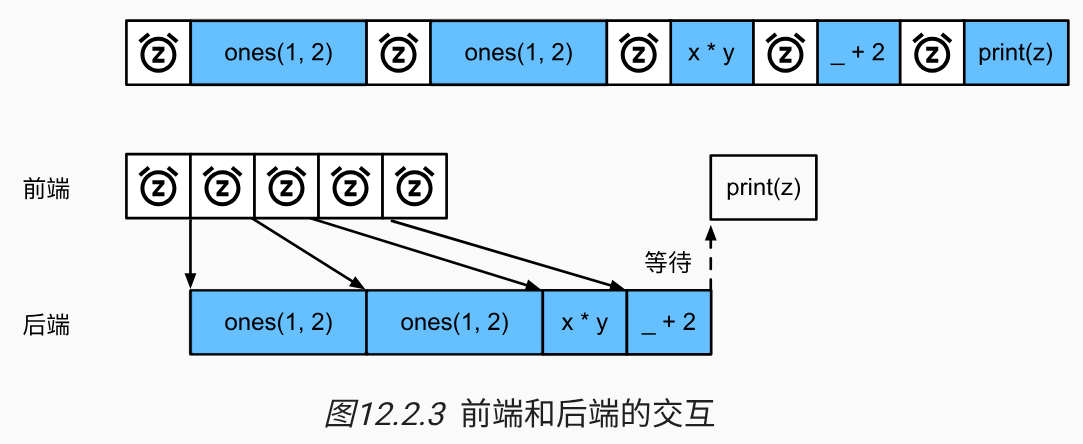

## 自动并行
`PyTorch`会根据数据流构建计算图, 并且互不相关的变量可以在不同的 `GPU` 上并行计算, 同时可以通过移动变量的方式完成不同设备之间的通信, 也就是使用 `torch.Tensor.to` 来移动张量或者模型, 例如在一个 `CPU` 和两个 `GPU` 上训练时的计算图以及依赖关系:
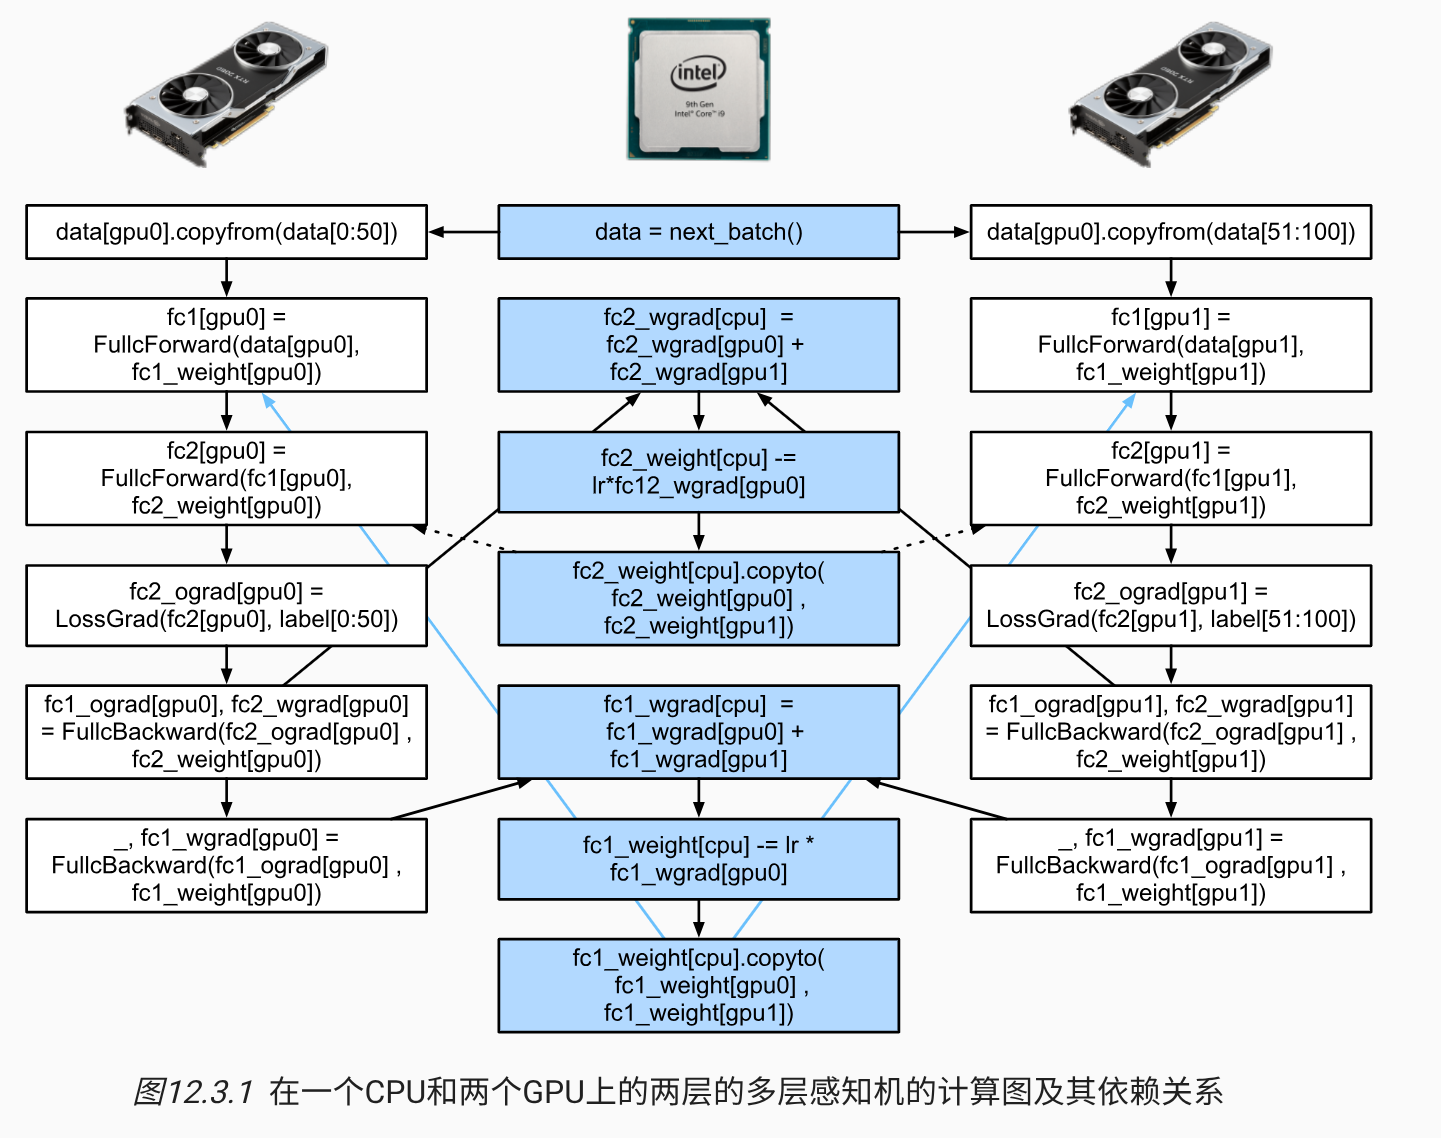

## 多GPU训练
> 多 `GPU` 训练过程中内部的各种屏障以及同步策略此时不需要考虑, 只需要考虑如何使用 `PyTorch API` 来实现屏障

具体实现可以使用 `PyTorch API` 中提供的 `nn.DataParallel` 来实现, 只需要传递模型以及设备即可, 同时在计算的过程中可以把张量移动到某一个 `GPU` 上

In [3]:
# 一种可能的并行训练方式
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')